In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
cd ~/workspace/theislab/mubind/docs/notebooks/dynamics

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/dynamics


In [72]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [73]:
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [74]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [75]:
adata.shape

(10000, 10000)

In [76]:
n_sample_cells = 100
n_sample_peaks = 100

In [77]:
adata.shape

(10000, 10000)

In [78]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [79]:
adata.shape

(100, 100)

In [80]:
adata.shape

(100, 100)

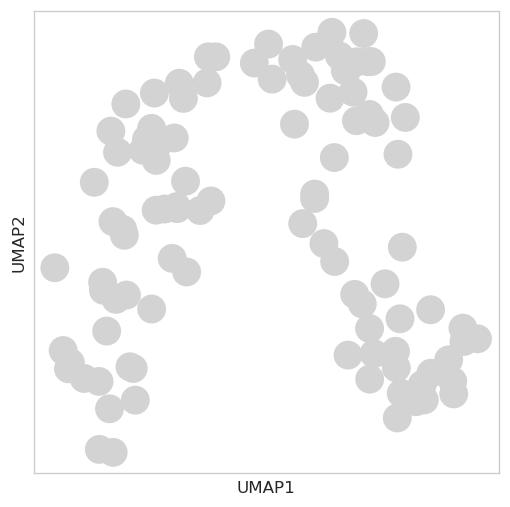

In [81]:
sc.pl.umap(adata)

In [82]:
adata.var

,modality
1-43152466-43153265,ATAC
1-43878967-43879816,ATAC
1-60534691-60535613,ATAC
1-157574959-157575802,ATAC
2-4816050-4816768,ATAC
...,...
19-6375951-6376625,ATAC
19-10688440-10689355,ATAC
19-45017613-45018410,ATAC
X-74417540-74418476,ATAC


In [83]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

In [84]:
extend = 50

adata.var['chr'].value_counts()

chr2     9
chr5     8
chr9     8
chr17    8
chr7     7
chr12    7
chr6     6
chr8     6
chr15    5
chr1     4
chr19    4
chr18    4
chr16    4
chr11    4
chr4     4
chr3     4
chr14    3
chr13    3
chrX     2
Name: chr, dtype: int64

In [85]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [86]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [87]:
adata.shape

(100, 100)

In [88]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpza760nqh
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpza760nqh -fo /tmp/tmpdxz43lsp


In [89]:
len(seqs)

100

In [90]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [91]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break



In [92]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [93]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(100, 101)

In [94]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [95]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [96]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [97]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,var
seq,,,,,,,,,,,,,,,,,,,,,
CGGGGCGCGGCGGAGGGGCAGTGCGGCTCGTTCTCAGCTGGACGCGGGAGTAAGTCACATCCGGTAGAGGCGGGGCTCGTGGATCCCGGAAGTGCGGGCA,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,...,2.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.044040
GGGCGCGCCACGATTGGAGAAATCCGTAACCAATCTGTAGCCTTAGCCCTGATACCGGAGCCAATCCCTGGTCAGAGCCACGAACCGCCTCCACCCCGCC,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,6.0,...,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.010101
AGCAACGACAAGCCGGATAACCGCTCTTGAGGTAAGCTGCAGGCGGTGAGGGGTCGCGTCGCCAAGTTTCCTTCTTGTGGGAGAAATTTGCAGTTCTGAG,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.890000
CCCCCGCGTGCGCCCTGGCTGGCACGCGTGACGTGGGTTACTTGCGCGTGTCCGCTCCCCGGGGCGGGAACGCCCCTCGGACCCCTCCCCCCATCAGTGC,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.715556
ACTTCCAGGCCGTGGTGGAGCGCGCGGCGCCACACGCGGGAGGCTGCGTGCGCGCGCTGTGCGGCCGAGGGCTGCTACGCGTGCTGGCGGGTAGCGCCTT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.650101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGAGTGGAGCCTTTTCTGGGTGTTGTGGGACTGGCTACAGAGTTTGCACCCAAGGTCTGCTCAGTGCACTGGCCCAGACCAGAAAAAACCCATGCCACTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TATGCTAGCCAATGCGTAAGGAGGAGCTGTTGAGCAATAAAACCAGAAACCACCCTGCATTTAAGCAATGCACTAAGTACATTCCTTTTAGAATAAAAGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AAATGTTAATTCTGTACAGCTTCAGAGAAGAAACATGGGATTCAAATTCTCTAAAATGTGTCTGTGCGCTTGATCCTGACAGGGAGAATTTTAAAGCTGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [98]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [99]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(85, 100)

In [100]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(8500, 3)
100
0     85
63    85
73    85
72    85
71    85
      ..
30    85
29    85
28    85
27    85
99    85
Name: batch, Length: 100, dtype: int64


,0,1,batch
seq,,,
CGGGGCGCGGCGGAGGGGCAGTGCGGCTCGTTCTCAGCTGGACGCGGGAGTAAGTCACATCCGGTAGAGGCGGGGCTCGTGGATCCCGGAAGTGCGGGCA,1.0,2.0,0
GGGCGCGCCACGATTGGAGAAATCCGTAACCAATCTGTAGCCTTAGCCCTGATACCGGAGCCAATCCCTGGTCAGAGCCACGAACCGCCTCCACCCCGCC,1.0,0.0,0
AGCAACGACAAGCCGGATAACCGCTCTTGAGGTAAGCTGCAGGCGGTGAGGGGTCGCGTCGCCAAGTTTCCTTCTTGTGGGAGAAATTTGCAGTTCTGAG,1.0,0.0,0
CCCCCGCGTGCGCCCTGGCTGGCACGCGTGACGTGGGTTACTTGCGCGTGTCCGCTCCCCGGGGCGGGAACGCCCCTCGGACCCCTCCCCCCATCAGTGC,1.0,1.0,0
ACTTCCAGGCCGTGGTGGAGCGCGCGGCGCCACACGCGGGAGGCTGCGTGCGCGCGCTGTGCGGCCGAGGGCTGCTACGCGTGCTGGCGGGTAGCGCCTT,1.0,1.0,0


### This is the relatedness graph and used for dynamics filters learning

In [101]:
# sum(adata.obs_names.isin(df.index)

In [102]:
len(seqs)

100

In [103]:
rel = adata[:,~zero_counts].uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape

(100, 100)

In [104]:
rel.shape

(100, 100)

In [105]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [106]:
n_batch = len(set(dataset.batch))
n_batch

1

In [107]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [108]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [109]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [124]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

n_kernels = 3
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + [20] * (n_kernels - 2),
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook

mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
print(mask.device)
print(model.selex_module.log_dynamic)

model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))


# here we set up the relationships between cells using the knn graph, for graph-based learning of activities
model.selex_module.connectivities = torch.tensor(rel).cuda()

cuda:0
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


In [125]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [126]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [127]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [1] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [1] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            skip_kernels=range(3, 100),
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.546238, R2: 0.20,  best epoch: 9,  secs per epoch: 0.014 s,  secs epoch*1k trials: 0.165s
Epoch: 21, Loss: 0.543285, R2: 0.21,  best epoch: 19,  secs per epoch: 0.013 s,  secs epoch*1k trials: 0.151s
Epoch: 31, Loss: 0.541049, R2: 0.22,  best epoch: 29,  secs per epoch: 0.013 s,  secs epoch*1k trials: 0.150s
Epoch: 41, Loss: 0.539344, R2: 0.23,  best epoch: 39,  secs per epoch: 0.014 s,  secs epoch*1k trials: 0.161s
Epoch: 51, Loss: 0.538029, R2: 0.23,  best epoch: 49,  secs per epoch: 0.015 s,  secs epoch*1k trials: 0.171s
Epoch: 61, Loss: 0.537007, R2: 0.24,  best epoch: 59, 

In [128]:
n_cols = len(model.binding_modes)

True
1


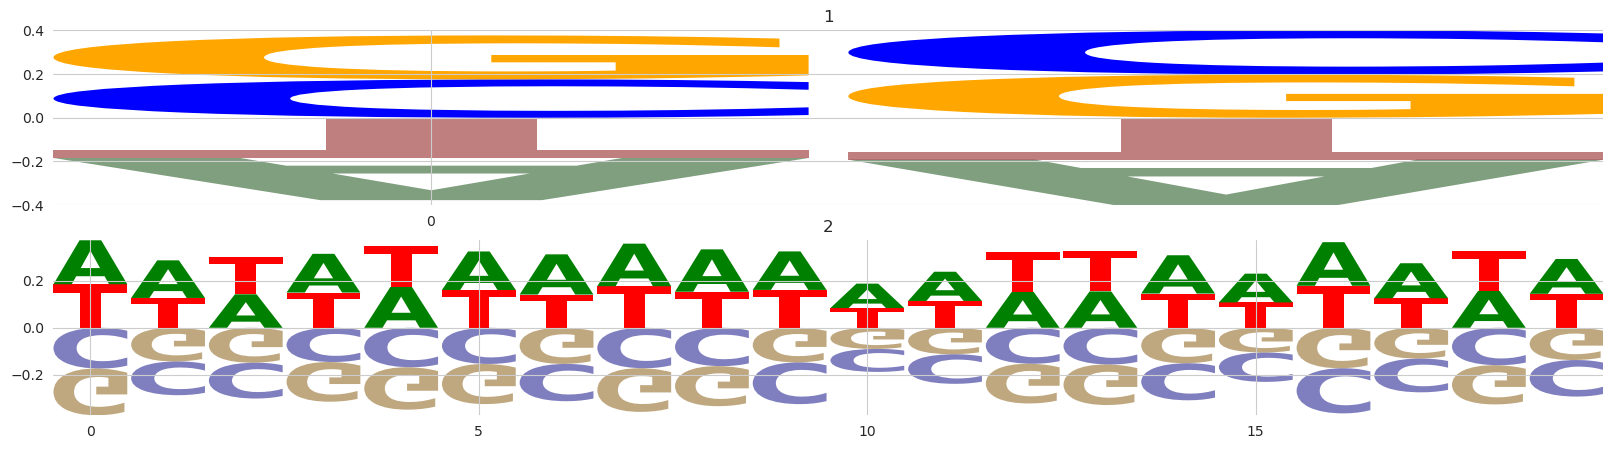

In [129]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=int(n_cols / 2), n_rows=2, show=True)
plt.show()


In [130]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [131]:
log_dynamic.max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

<AxesSubplot: >

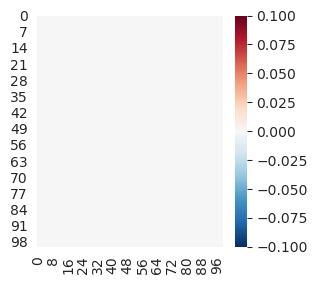

In [132]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(log_dynamic.detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

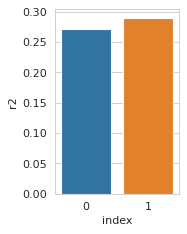

In [133]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [134]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic.sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [135]:
torch.set_printoptions(precision=2)
log_dynamic = log_dynamic.detach().cpu().numpy()

n_rounds = model.selex_module.n_rounds
triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic[triu_indices[0], triu_indices[1]] = 0
dynamic_score = log_dynamic.sum(axis=0)


In [136]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

StopIteration: 

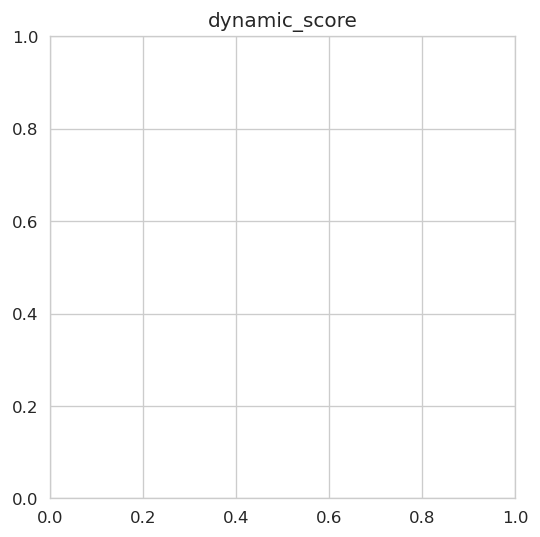

In [137]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
